## Solving the 2D Heat Equation using Physics-Informed Neural Networks (PINNs)

In this notebook, we demonstrate how to solve the **2D time-dependent heat equation** using a **Physics-Informed Neural Network (PINN)**. Unlike traditional machine learning models that rely heavily on large datasets, PINNs embed **physical laws (PDEs)** directly into the loss function.

We solve the following PDE:

$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

on the domain \\( (x, y, t) \in [0,1]^2 \times [0,1] \\), with:

- **Initial condition**: \\( u(x, y, 0) = \sin(\pi x)\sin(\pi y) \\)
- **Boundary condition**: \\( u = 0 \\) on all edges
- **Thermal diffusivity**: \\( \alpha = 0.01 \\)

We will train a neural network to approximate the solution \\( u(x, y, t) \\), guided by both sparse data and physics.


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Activate GPU
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Neural Network Architecture

We define a fully connected feedforward neural network `FCNet` to approximate the solution \\( u(x, y, t) \\). The network takes a 3D input (\\(x, y, t\\)) and outputs a scalar \\( u \\).

We use multiple hidden layers with the **Tanh** activation function, which works well for approximating smooth functions like PDE solutions.


In [4]:
# Fully Connected Neural Network
class FCNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers) -2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(nn.Tanh())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)

## Enforcing Boundary Conditions with a Hard Constraint

Instead of penalizing non-zero values at the boundary, we modify the network output to satisfy the condition exactly:

$$
u(x, y, t) = x(1 - x)y(1 - y) \cdot \text{NN}(x, y, t)
$$

This guarantees that \( u = 0 \) on all edges of the domain, satisfying the Dirichlet boundary condition by design.


In [15]:
class HardBCNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers) - 2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(nn.Tanh())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*net)

    def forward(self, xyt):
        x = xyt[:, 0:1]
        y = xyt[:, 1:2]
        t = xyt[:, 2:3]

        u_nn = self.model(torch.cat([x, y, t], dim=1))
        mask = x * (1 - x) * y * (1 - y)  # zero on domain edges
        return mask * u_nn


In [5]:
model = FCNet([3, 64, 64, 64, 1])
print(model)

FCNet(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [16]:
model = HardBCNet([3, 128, 128, 128, 1])
print(model)

HardBCNet(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


## Sampling Training Points

We divide our training data into three categories:

- **Collocation (interior) points**: Random points in the full space-time domain \\( [0,1]^2 \times [0,1] \\). These are used to enforce the PDE.
- **Boundary points**: Points where either \\( x = 0, x = 1 \\) or \\( y = 0, y = 1 \\). These enforce Dirichlet boundary conditions.
- **Initial condition points**: Points at \\( t = 0 \\). These enforce the known initial state of the system.


In [6]:
# 1 Collocation / Interior points: random in [0, 1]^3
def sample_collection_points(N):
    x = np.random.rand(N, 1)
    y = np.random.rand(N, 1)
    t = np.random.rand(N, 1)
    return x, y, t

# 2 Sample boundary points (x=0 or 1, or y = 0 or 1)
def sample_boundary_points(N):
    assert N%4 == 0, "N must be divisible by 4"

    quarter = N//4

    x = np.vstack([
        np.zeros((quarter, 1)),       # x = 0 edge
        np.ones((quarter, 1)),        # x = 1 edge
        np.random.rand(quarter, 1),   # x varies (for y=0 & y=1 edges)
        np.random.rand(quarter, 1)
    ])
    y = np.vstack([
        np.random.rand(quarter, 1),  # y varies on x=0 edge
        np.random.rand(quarter, 1),  # y varies on x=1 edge
        np.zeros((quarter, 1)),      # y = 0 -> bottom edge
        np.ones((quarter, 1))        # y = 1 -> top edge
    ])
    t = np.random.rand(N, 1)
    return x, y, t

# 3 Sample initial condition points (t = 0)
def sample_initial_points(N):
    x = np.random.rand(N, 1)
    y = np.random.rand(N, 1)
    t = np.zeros((N, 1))
    return x, y, t

## Visualizing Boundary Points

We sample points on the spatial boundaries of the square domain \\( [0,1]^2 \\). Each boundary (left, right, top, bottom) is shown in a different color. These points will be used to enforce the boundary condition \\( u = 0 \\) during training.


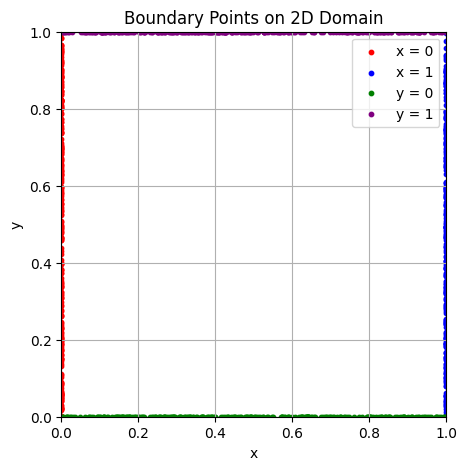

((1000, 1), (1000, 1))

In [7]:
# Visualize boundary point distribution
def plot_boundary_points(x, y):
    #x = x.ravel()
    #y = y.ravel()
    plt.figure(figsize=(5,5))

    N = len(x)

    # Four groups of N/4 each
    plt.scatter(x[:N//4], y[:N//4], c='red', label='x = 0', s=10)
    plt.scatter(x[N//4:N//2], y[N//4:N//2], c='blue', label='x = 1', s=10)
    plt.scatter(x[N//2:3*N//4], y[N//2:3*N//4], c='green', label='y = 0', s=10)
    plt.scatter(x[3*N//4:], y[3*N//4:], c='purple', label='y = 1', s=10)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Boundary Points on 2D Domain')
    plt.legend()
    plt.grid(True)
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

# Sample and plot
x_bc, y_bc, t_bc = sample_boundary_points(1000)
plot_boundary_points(x_bc, y_bc)
x_bc.shape, y_bc.shape

## Tensor Preparation & Initial Condition

We now:
- Convert all sampled points from NumPy to PyTorch tensors
- Enable gradient tracking so we can compute derivatives later (needed for PDE loss)
- Compute the initial condition values using the known expression:

$$
u(x, y, 0) = \sin(\pi x) \sin(\pi y)
$$

This will be used to compute the loss against the network's prediction at \( t = 0 \).


In [8]:
# Convert to PyTorch tensors (with gradient tracking)
def to_tensor(*arrays):
    return [torch.tensor(a, dtype=torch.float32, requires_grad=True).to(device) for a in arrays]

# Sample data
N_int = 10000
N_bc = 1000
N_ic = 1000

x_int, y_int, t_int = sample_collection_points(N_int)
x_bc, y_bc, t_bc = sample_boundary_points(N_bc)
x_ic, y_ic, t_ic = sample_initial_points(N_ic)

# Convert to torch tensor
X_int, Y_int, T_int = to_tensor(x_int, y_int, t_int)
X_bc, Y_bc, T_bc = to_tensor(x_bc, y_bc, t_bc)
X_ic, Y_ic, T_ic = to_tensor(x_ic, y_ic, t_ic)

# Ground truth initial conditions: u(x,y, 0) = sin(pi * x) * sin(pi * y)
U_ic_true = (torch.sin(np.pi * X_ic) * torch.sin(np.pi * Y_ic)).detach()

## Physics-Informed Loss (PDE Residual)

This function computes the residual of the heat equation at interior (collocation) points:

$$
\mathcal{R}(x, y, t) = \frac{\partial u}{\partial t} - \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

We:
- Use PyTorch autograd to compute the needed derivatives
- Stack \\( x, y, t \\) as input and evaluate the model
- Return the **mean squared residual** as the physics loss

This encourages the network to produce solutions that obey the PDE.


In [9]:
# Physics Loss (PDE residual)
def physics_loss(model, x, y, t, alpha):

    # Ensure gradients are computed (Important)
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    inputs = torch.cat([x, y, t], dim=1) # shape: [N, 3]
    u = model(inputs)

    # First derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second derivatives
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # PDE residual
    residual = u_t - alpha * (u_xx + u_yy)

    return torch.mean(residual**2)

## Training the PINN

We train the neural network using a combination of three loss terms:

1. **Physics loss**: encourages the solution to satisfy the heat equation at interior points
2. **Initial condition loss**: ensures the predicted solution matches the known initial state
3. **Boundary condition loss**: forces the solution to be zero at the domain boundaries

The total loss is:

$$
\mathcal{L} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{IC}} + \mathcal{L}_{\text{BC}}
$$

We use the Adam optimizer and train for 5000 epochs.


In [10]:
# Params
alpha = 0.01
layers = [3] + [128]*3 + [1]
model = FCNet(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2001

for epoch in range(epochs):
    optimizer.zero_grad()

    # Physics loss
    loss_pde = physics_loss(model, X_int, Y_int, T_int, alpha)

    # Boundary Condition Loss
    Xb = torch.cat([X_ic, Y_ic, T_bc], dim=1)
    u_bc_pred = model(Xb)
    loss_bc = torch.mean(u_bc_pred**2)

    # Initial Condition Loss
    Xi = torch.cat([X_ic, Y_ic, T_ic], dim=1)
    u_ic_pred = model(Xi)
    loss_ic = torch.mean((u_ic_pred - U_ic_true)**2)

    # Total loss
    loss = loss_pde + loss_bc + loss_ic
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == epoch - 1:
        print(f"Epoch {epoch:4d} | Total: {loss.item():.2e} | PDE: {loss_pde.item():.2e} | IC: {loss_ic.item():.2e} | BC: {loss_bc.item():.2e}")

Epoch    0 | Total: 2.72e-01 | PDE: 2.49e-03 | IC: 2.69e-01 | BC: 9.12e-04
Epoch  100 | Total: 1.55e-01 | PDE: 9.78e-03 | IC: 1.11e-01 | BC: 3.48e-02
Epoch  200 | Total: 1.11e-01 | PDE: 9.85e-03 | IC: 4.74e-02 | BC: 5.32e-02
Epoch  300 | Total: 1.06e-01 | PDE: 1.23e-02 | IC: 4.21e-02 | BC: 5.16e-02
Epoch  400 | Total: 1.04e-01 | PDE: 1.29e-02 | IC: 4.38e-02 | BC: 4.75e-02
Epoch  500 | Total: 1.04e-01 | PDE: 1.30e-02 | IC: 4.11e-02 | BC: 4.96e-02
Epoch  600 | Total: 1.03e-01 | PDE: 1.31e-02 | IC: 4.13e-02 | BC: 4.91e-02
Epoch  700 | Total: 1.03e-01 | PDE: 1.31e-02 | IC: 4.07e-02 | BC: 4.94e-02
Epoch  800 | Total: 1.07e-01 | PDE: 1.11e-02 | IC: 2.79e-02 | BC: 6.82e-02
Epoch  900 | Total: 1.03e-01 | PDE: 1.31e-02 | IC: 4.05e-02 | BC: 4.95e-02
Epoch 1000 | Total: 1.03e-01 | PDE: 1.31e-02 | IC: 4.04e-02 | BC: 4.94e-02
Epoch 1100 | Total: 1.03e-01 | PDE: 1.31e-02 | IC: 4.03e-02 | BC: 4.94e-02
Epoch 1200 | Total: 1.03e-01 | PDE: 1.30e-02 | IC: 3.96e-02 | BC: 5.01e-02
Epoch 1300 | Total: 1.03e

## Comparing PINN Prediction vs Exact Solution

We now evaluate the trained PINN at a snapshot in time (e.g., \( t = 0.5 \)) and compare it to the analytical solution:

$$
u(x, y, t) = \sin(\pi x)\sin(\pi y)e^{-2\pi^2 \alpha t}
$$

We visualize both the predicted and exact solutions on the domain \( [0, 1]^2 \).


In [11]:
# Evaluation function
def evaluate(model, alpha, t_eval=1.0):
    x = y = np.linspace(0, 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    T_grid = np.full_like(X_grid, t_eval)

    # Stack into (N, 3) tensor
    X_test = torch.tensor(
        np.stack([X_grid.ravel(), Y_grid.ravel(), T_grid.ravel()], axis=-1),
        dtype=torch.float32
    ).to(device)

    # Predict
    with torch.no_grad():
        u_pred = model(X_test).cpu().numpy().reshape(100, 100)

    # Exact solution
    u_exact = np.sin(np.pi * X_grid) * np.sin(np.pi * Y_grid) * np.exp(-2 * np.pi**2 * alpha * t_eval)

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(u_pred, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    plt.title(f"PINN Prediction at t = {t_eval}")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(u_exact, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    plt.title(f"Exact Solution at t = {t_eval}")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


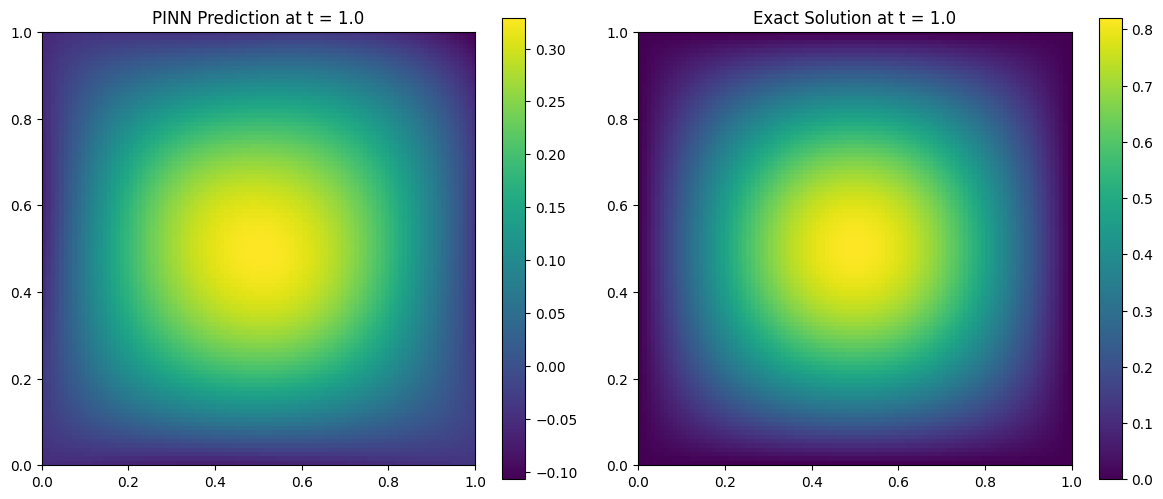

In [12]:
evaluate(model, alpha, t_eval=1.0)


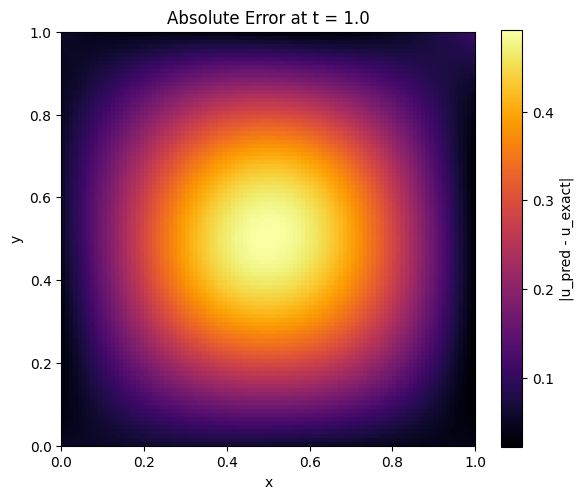

In [13]:
def error_visualization(model, alpha=0.01, t_eval=0.5):
    x = y = np.linspace(0, 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    T_grid = np.full_like(X_grid, t_eval)

    X_test = torch.tensor(
        np.stack([X_grid.ravel(), Y_grid.ravel(), T_grid.ravel()], axis=-1),
        dtype=torch.float32
    ).to(device)

    with torch.no_grad():
        u_pred = model(X_test).cpu().numpy().reshape(100, 100)

    u_exact = np.sin(np.pi * X_grid) * np.sin(np.pi * Y_grid) * np.exp(-2 * np.pi**2 * alpha * t_eval)
    abs_error = np.abs(u_pred - u_exact)

    plt.figure(figsize=(6, 5))
    plt.imshow(abs_error, origin='lower', extent=[0, 1, 0, 1], cmap='inferno')
    plt.title(f'Absolute Error at t = {t_eval}')
    plt.colorbar(label='|u_pred - u_exact|')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

# Example usage
error_visualization(model, alpha, t_eval=1.0)


In [14]:
from matplotlib import animation

def animate_solution(model, alpha=0.01, timesteps=20):
    x = y = np.linspace(0, 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)

    fig, ax = plt.subplots(figsize=(6, 5))
    img = ax.imshow(np.zeros_like(X_grid), origin='lower', extent=[0,1,0,1], vmin=0, vmax=1, cmap='viridis')
    plt.colorbar(img, ax=ax)
    #ax.set_title("PINN Prediction Over Time")

    def update(frame):
        t_val = frame / (timesteps - 1)
        T_grid = np.full_like(X_grid, t_val)
        X_test = torch.tensor(
            np.stack([X_grid.ravel(), Y_grid.ravel(), T_grid.ravel()], axis=-1),
            dtype=torch.float32
        ).to(device)

        with torch.no_grad():
            u_pred = model(X_test).cpu().numpy().reshape(100, 100)

        img.set_data(u_pred)
        ax.set_title(f"PINN Prediction Over Time t = {t_val:.2f}")
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=timesteps, interval=200)
    plt.close()
    return ani

# Run in Jupyter to display:
ani = animate_solution(model, alpha)
from IPython.display import HTML
HTML(ani.to_jshtml())


In [19]:
# Params
alpha = 0.01
layers = [3] + [128]*3 + [1]
model_Hard = HardBCNet(layers).to(device)
optimizer = torch.optim.Adam(model_Hard.parameters(), lr=1e-3)
epochs = 2001

for epoch in range(epochs):
    optimizer.zero_grad()

    # Physics loss
    loss_pde = physics_loss(model_Hard, X_int, Y_int, T_int, alpha)

    # Boundary Condition Loss
    Xb = torch.cat([X_ic, Y_ic, T_bc], dim=1)
    u_bc_pred = model_Hard(Xb)
    loss_bc = torch.mean(u_bc_pred**2)

    # Initial Condition Loss
    Xi = torch.cat([X_ic, Y_ic, T_ic], dim=1)
    u_ic_pred = model_Hard(Xi)
    loss_ic = torch.mean((u_ic_pred - U_ic_true)**2)

    # Total loss
    loss = loss_pde + loss_ic #+ loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == epoch - 1:
        print(f"Epoch {epoch:4d} | Total: {loss.item():.2e} | PDE: {loss_pde.item():.2e} | IC: {loss_ic.item():.2e} | BC: {loss_bc.item():.2e}")

Epoch    0 | Total: 2.71e-01 | PDE: 1.08e-06 | IC: 2.71e-01 | BC: 2.62e-05
Epoch  100 | Total: 8.31e-03 | PDE: 6.59e-03 | IC: 1.72e-03 | BC: 2.28e-01
Epoch  200 | Total: 1.53e-03 | PDE: 8.31e-04 | IC: 6.99e-04 | BC: 2.14e-01
Epoch  300 | Total: 1.49e-03 | PDE: 7.95e-04 | IC: 6.91e-04 | BC: 2.15e-01
Epoch  400 | Total: 1.46e-03 | PDE: 7.75e-04 | IC: 6.89e-04 | BC: 2.15e-01
Epoch  500 | Total: 1.43e-03 | PDE: 7.42e-04 | IC: 6.85e-04 | BC: 2.15e-01
Epoch  600 | Total: 1.32e-03 | PDE: 6.50e-04 | IC: 6.73e-04 | BC: 2.15e-01
Epoch  700 | Total: 1.01e-03 | PDE: 4.13e-04 | IC: 5.95e-04 | BC: 2.15e-01
Epoch  800 | Total: 4.01e-04 | PDE: 1.00e-04 | IC: 3.00e-04 | BC: 2.15e-01
Epoch  900 | Total: 1.20e-04 | PDE: 4.92e-05 | IC: 7.04e-05 | BC: 2.16e-01
Epoch 1000 | Total: 4.72e-05 | PDE: 2.53e-05 | IC: 2.19e-05 | BC: 2.17e-01
Epoch 1100 | Total: 1.96e-05 | PDE: 1.22e-05 | IC: 7.38e-06 | BC: 2.17e-01
Epoch 1200 | Total: 1.07e-05 | PDE: 7.65e-06 | IC: 3.07e-06 | BC: 2.17e-01
Epoch 1300 | Total: 7.25e

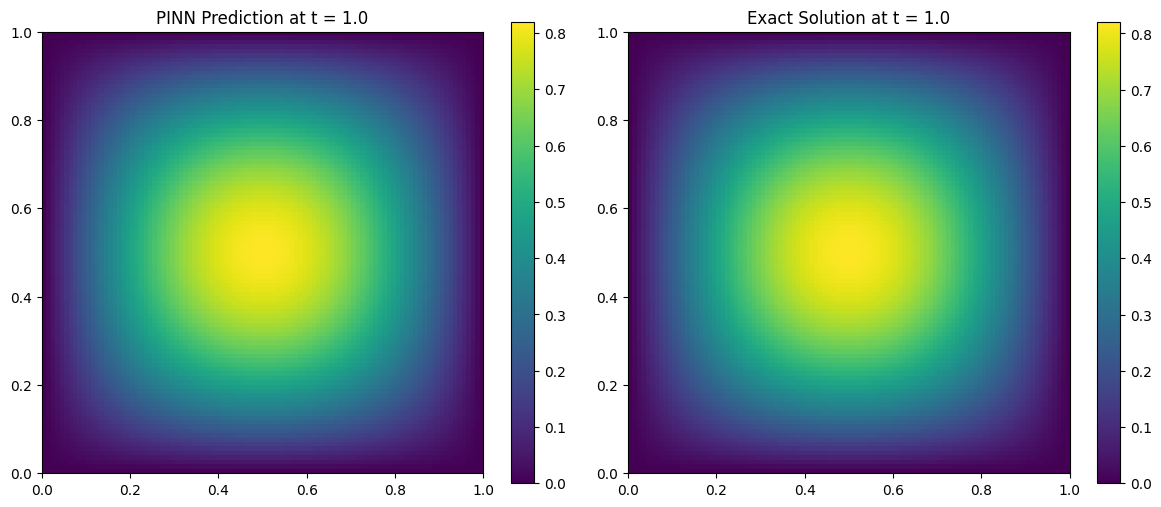

In [20]:
evaluate(model_Hard, alpha, t_eval=1.0)

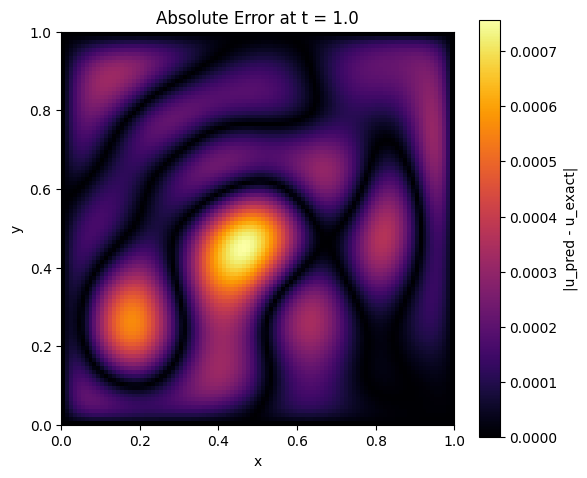

In [21]:
error_visualization(model_Hard, alpha, t_eval=1.0)